# Машинное обучение – весна 2024

# Домашнее задание 2: Логистическая регрессия, метод опорных векторов, работа с текстами

Правила:

- Домашнее задание оценивается в 10 баллов.

- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

- Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

- Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

# Задание 1: LR, SVM и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: Метод predict_proba используется для получения векторов вероятностей принадлежности объектов каждому классу.

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [4]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


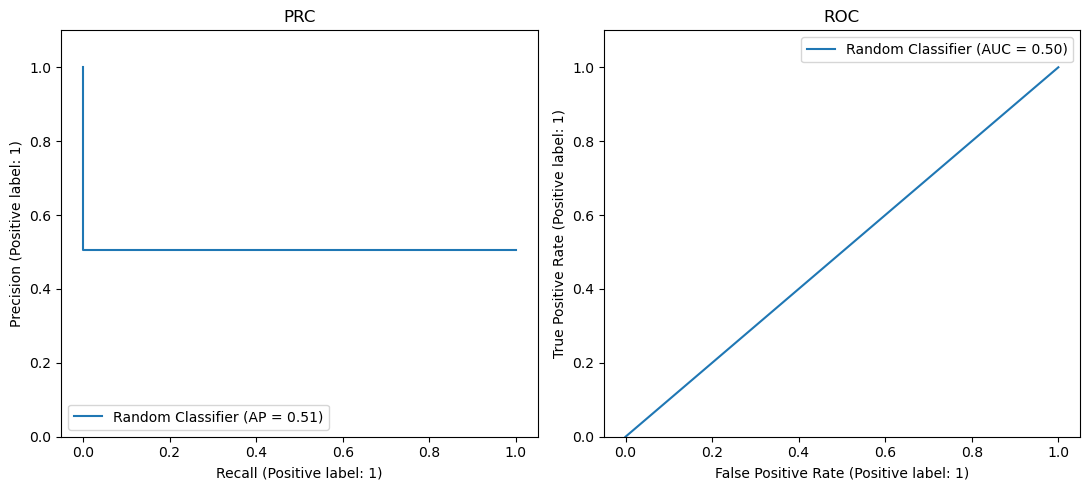

In [5]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    print('AUC-PR: %.5f' % auc(recall, precision))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [6]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [7]:
from sklearn.svm import SVC

In [8]:
parametrs = [0.01, 0.1, 1, 10, 100]
svm_array = []
auc_array = []

X_train_, X_valid_, y_train_, y_valid_ = train_test_split(X_train, y_train, test_size=0.3, random_state=7)

for c in parametrs:
    svm = SVC(C=c, kernel="linear", probability=True)
    svm.fit(X_train_, y_train_)
    svm_array.append(svm)
    y_valid_predict = svm.predict_proba(X_valid_)[:,1]
    
    precision, recall, _ = precision_recall_curve(y_valid_, y_valid_predict)
    auc_array.append(auc(recall, precision))
    
pd.DataFrame({'Parametrs': parametrs, 'AUC': auc_array})

,Parametrs,AUC
0,0.01,0.792579
1,0.10,0.792220
2,1.00,0.792188
3,10.00,0.792247
4,100.00,0.792287


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

AUC-PR: 0.79258
AUC-ROC: 0.84802


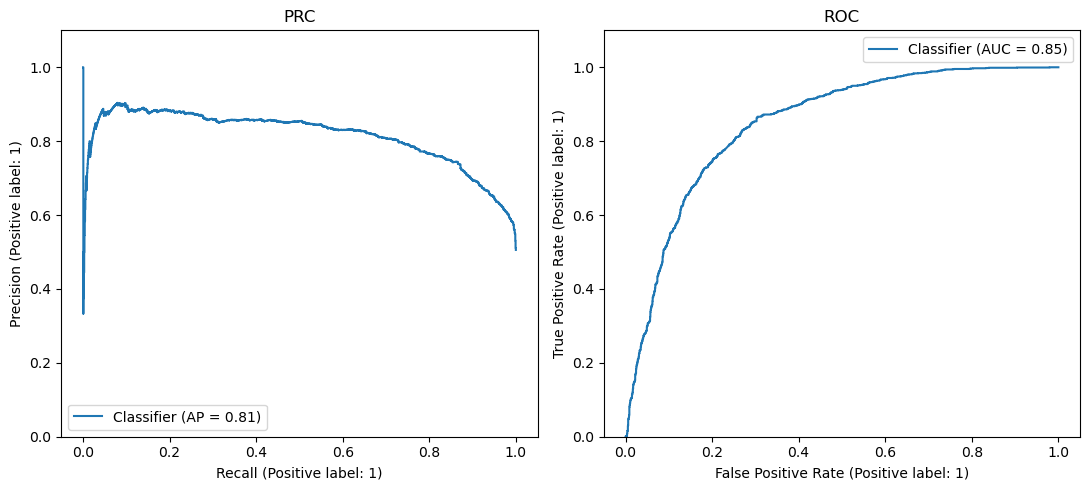

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

y_test_predict_0 = svm_array[0].predict_proba(X_test)[:,1]

PrecisionRecallDisplay.from_predictions(y_test, y_test_predict_0, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, y_test_predict_0)
auc_0 = auc_array[0]
print('AUC-PR: %.5f' % auc_0)
ax[0].set_title("PRC")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_test_predict_0, ax=ax[1])
roc_auc_0 = roc_auc_score(y_test, y_test_predict_0)
print('AUC-ROC: %.5f' % roc_auc_0)
ax[1].set_title("ROC")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()
plt.legend()

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [10]:
precision, recall, _ = precision_recall_curve(y_test, y_random)
auc_random = auc(recall, precision)
roc_auc_random = roc_auc_score(y_test, y_random)

auc_roc_array = [auc_random, auc_0]
auc_pr_array = [roc_auc_random, roc_auc_0]
model = ['Cлучайный классификатор', 'SVM']

pd.DataFrame({"Модель": model, "AUC-ROC": auc_roc_array, "AUC-PR": auc_pr_array})

,Модель,AUC-ROC,AUC-PR
0,Cлучайный классификатор,0.752833,0.500000
1,SVM,0.792579,0.848019


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
lr_array = []
auc_array_1 = []

for c in parametrs:
    lr = LogisticRegression(C=c, penalty = 'l2')
    lr.fit(X_train_, y_train_)
    lr_array.append(lr)
    y_valid_predict_1 = lr.predict_proba(X_valid_)[:,1]
    
    precision, recall, _ = precision_recall_curve(y_valid_, y_valid_predict_1)
    auc_array_1.append(auc(recall, precision))
    
pd.DataFrame({'Parametrs': parametrs, 'AUC': auc_array_1})

,Parametrs,AUC
0,0.01,0.811733
1,0.10,0.810397
2,1.00,0.810275
3,10.00,0.810252
4,100.00,0.810249


AUC-PR: 0.81173
AUC-ROC: 0.84789


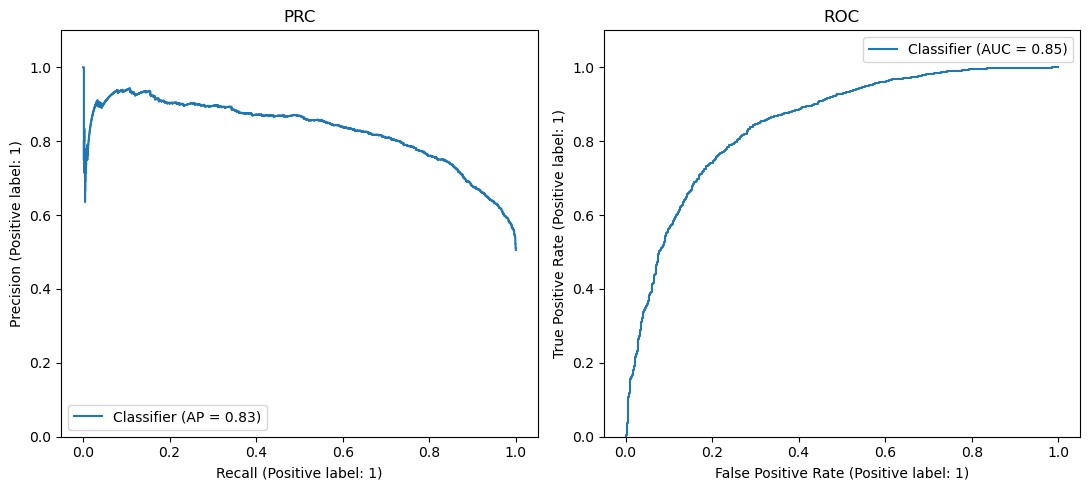

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

y_test_predict_1 = lr_array[0].predict_proba(X_test)[:,1]

PrecisionRecallDisplay.from_predictions(y_test, y_test_predict_1, ax=ax[0])
auc_1 = auc_array_1[0]
print('AUC-PR: %.5f' % auc_1)
ax[0].set_title("PRC")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_test_predict_1, ax=ax[1])
roc_auc_1 = roc_auc_score(y_test, y_test_predict_1)
print('AUC-ROC: %.5f' % roc_auc_1)
ax[1].set_title("ROC")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()
plt.legend()

In [14]:
auc_roc_array = [auc_random, auc_array_1[0]]
auc_pr_array = [roc_auc_random, roc_auc_1]
model = ['Cлучайный классификатор', 'Логистическая регрессия']

pd.DataFrame({"Модель": model, "AUC-ROC": auc_roc_array, "AUC-PR": auc_pr_array})

,Модель,AUC-ROC,AUC-PR
0,Cлучайный классификатор,0.752833,0.500000
1,Логистическая регрессия,0.811733,0.847889


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

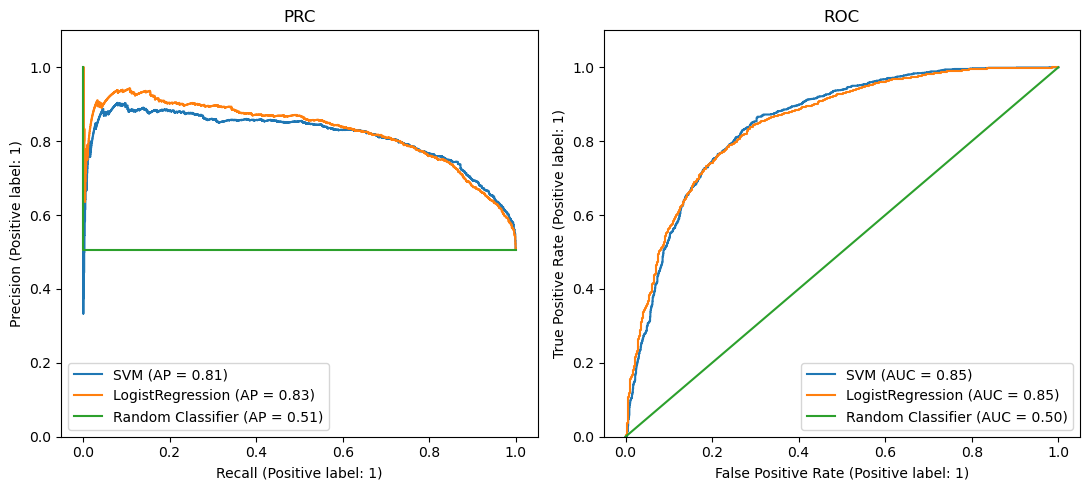

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, y_test_predict_0, ax=ax[0], name='SVM')
PrecisionRecallDisplay.from_predictions(y_test, y_test_predict_1, ax=ax[0], name='LogistRegression')
PrecisionRecallDisplay.from_predictions(y_test, y_random, ax=ax[0], name='Random Classifier')
ax[0].set_title("PRC")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_test_predict_0, ax=ax[1], name='SVM')
RocCurveDisplay.from_predictions(y_test, y_test_predict_1, ax=ax[1], name='LogistRegression')
RocCurveDisplay.from_predictions(y_test, y_random, ax=ax[1], name='Random Classifier')
ax[1].set_title("ROC")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()
plt.legend()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** Результаты LR незначительно лучше результатов SVM. Возможно причина этого в том что классы плохо разделимы и SVM опирается на большое число опорных объектов.

#### __Задание 1.2 Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [16]:
X, y = make_classification(n_features=2, n_redundant=0, random_state=42)

In [17]:
model = SVC(kernel="linear")
model.fit(X, y)

SVC(kernel='linear')

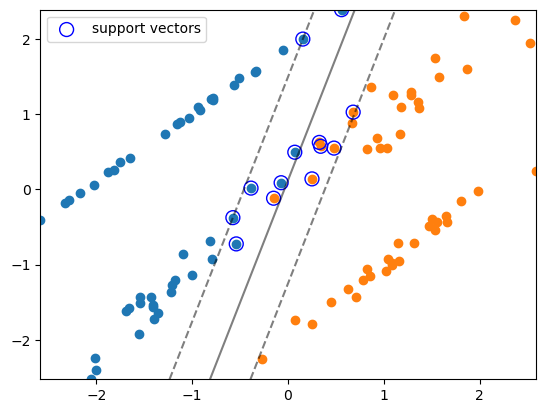

In [18]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)
    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    #Отрисовали выборку
    mask = (y == 0)
    X_0 = X[mask].T
    X_1 = X[~mask].T
    plt.scatter(X_0[0], X_0[1])
    plt.scatter(X_1[0], X_1[1])
    
    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:,0],
                   model.support_vectors_[:,1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')
    
    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:**  Опорными выделяются объекты, для которых $y_i(<x_i,w>)$ мало (в линейно-разделимом варианте $<1$), то есть объекты, близкие к разделяющей поверхности или неверно классифицированные объекты.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

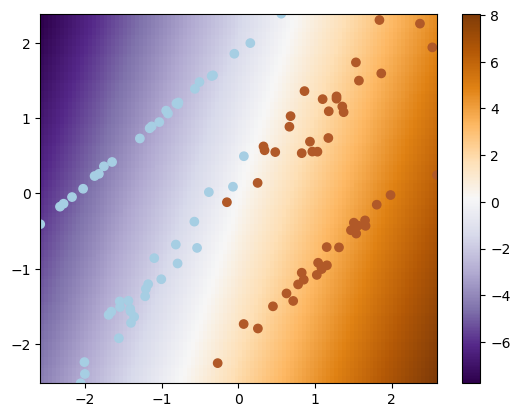

In [19]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.decision_function(xy).reshape(XX.shape)
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    mask = (y == 0)
    X_0 = X[mask].T
    X_1 = X[~mask].T
    plt.scatter(X.T[0], X.T[1], c=y, cmap=plt.cm.Paired)

    plt.colorbar(image)


plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Область, где модель не уверена выделена белым цветом. В этой области модель не знает, к какому классу отнести объект, здесь проходит разделяющая поверхность модели.

#### __Задание 1.3 Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [20]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)]))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

**Внимание:** для получения вероятностей из метода опорных векторов требуется использовать формулу:

$$probas = \frac{preds - min(preds)}{max(preds) - min(preds)}$$

где $preds$ - результат работы метода decision_function

In [21]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

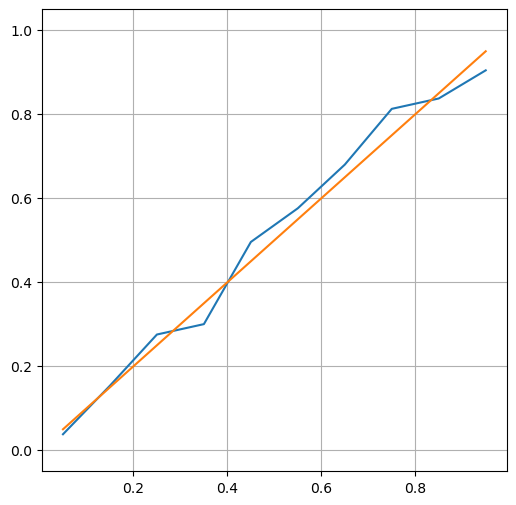

In [22]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict_proba(X_test)[:,1]

plot_calibration_curve(y_test, y_predict)

plt.plot([0.05, 0.95], [0.05, 0.95])

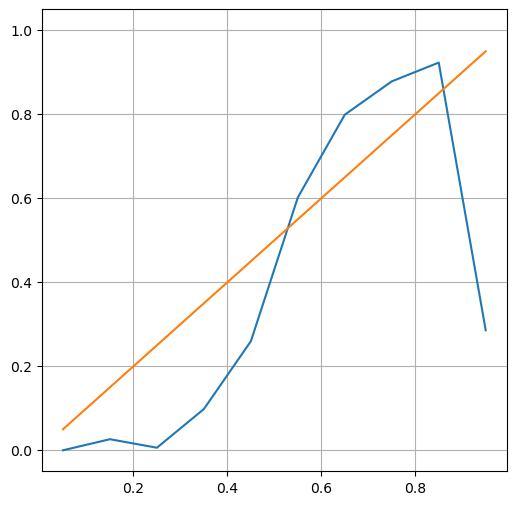

In [23]:
svm = SVC(kernel="linear")
svm.fit(X_train, y_train)
y_predict_1 = svm.decision_function(X_test)
y_predict_probas = (y_predict_1 - min(y_predict_1))/(max(y_predict_1) - min(y_predict_1))

plot_calibration_curve(y_test, y_predict_probas)

plt.plot([0.05, 0.95], [0.05, 0.95])

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** Кривая для логистической регрессии откалибрована хорошо, поскольку калибровочная кривая близка к кривой идеально откалиброванной модели. Кривая для SVM откалибрована плохо.

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

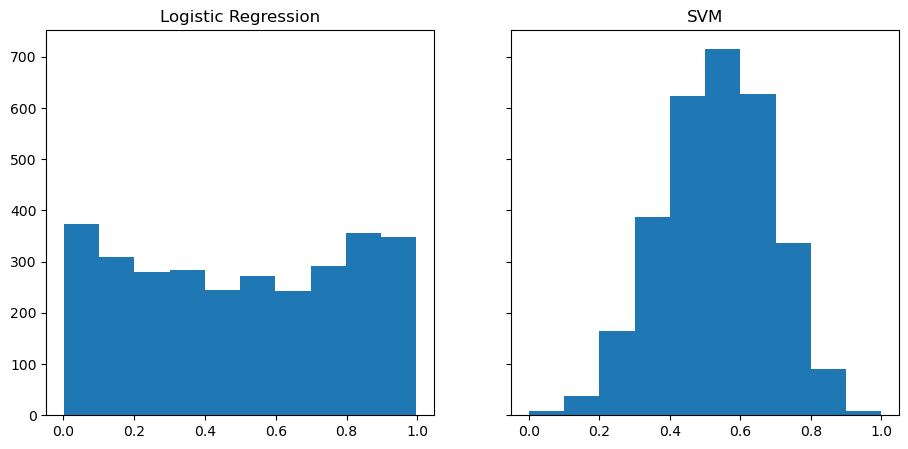

In [24]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(11, 5))
ax[0].hist(y_predict)
ax[0].set_title('Logistic Regression')
ax[1].hist(y_predict_probas)
ax[1].set_title('SVM')
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Распределение ответов логистической регрессии близко к равномерному, в то время как распределение ответов SVM близко к нормальному. Исходя из калибровочной кривой SVM моделью предсказывается меньшая вероятность класса 0 и класса 1, чем могла бы. Также судя по гистограмме большинство объектов относится к промежуточным вероятностям. Таким образом, классификатор сильно не уверен. Такое могло случиться, потому что SVM сильно концентрирует внимание на сложных для классификации объектах, близких к разделяющей поверхности.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [25]:
from sklearn.calibration import CalibratedClassifierCV

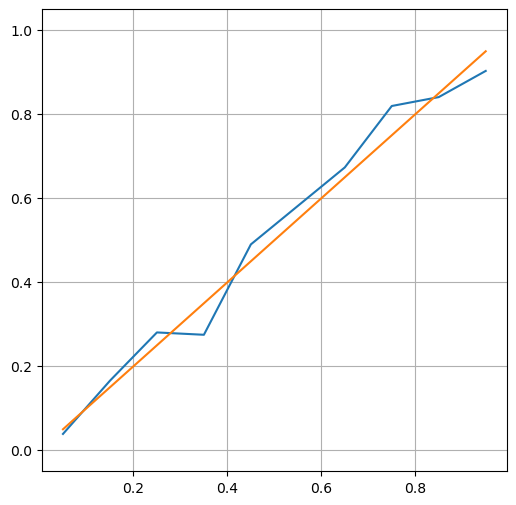

In [26]:
calibrated_svm = CalibratedClassifierCV()
calibrated_svm.fit(X_train, y_train)
y_predict_2 = calibrated_svm.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, y_predict_2)

plt.plot([0.05, 0.95], [0.05, 0.95])

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** Калибровочная кривая SVM стала ближе к кривой идеальной модели, однозначно улучшилась.

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [27]:
#your code here

# Задание 2: Работа с текстами (8 баллов)

В этой части домашнего задания будем строить классификатор текстов!

Возьмем [данные из Kaggle соревнования](https://www.kaggle.com/competitions/nlp-getting-started/data)


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
data = pd.read_csv('data/train.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

#### __Задание 2.1  Пропуски__ (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [4]:
train.isnull().sum()

id             0
keyword       44
location    1760
text           0
target         0
dtype: int64

In [5]:
train.fillna('', inplace = True)
train.head()

,id,keyword,location,text,target
1186,1707,bridge%20collapse,,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0
4071,5789,hail,"Carol Stream, Illinois",GREAT MICHIGAN TECHNIQUE CAMP\nB1G THANKS TO @...,1
5461,7789,police,Houston,CNN: Tennessee movie theater shooting suspect ...,1
5787,8257,rioting,,Still rioting in a couple of hours left until ...,1
7445,10656,wounds,Lake Highlands,Crack in the path where I wiped out this morni...,0


#### __Задание 2.2  Разведочный анализ данных__ (1 балл)

Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [6]:
train['target'].value_counts()

target
0    3024
1    2305
Name: count, dtype: int64

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

keyword
damage        36
siren         35
wreckage      34
fatalities    33
deluge        31
refugees      30
derail        30
fear          30
tsunami       30
fatality      30
Name: count, dtype: int64


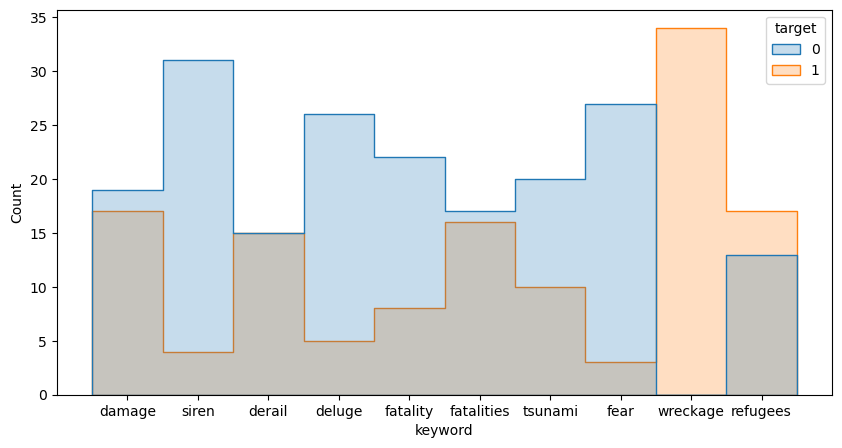

In [9]:
popular_keywords = train['keyword'].value_counts()[1:11]
print(popular_keywords)

popular_keywords_index = popular_keywords.index
popular_target = train[train['keyword'].isin(popular_keywords_index)]
popular_target

plt.figure(figsize=(10, 5))
sns.histplot(popular_target, x = 'keyword', hue='target', element='step')
plt.show()

**Ответ:** Без учета пропусков прослеживается следующая картина: ключевое слово wrekage однозначно говорит о принадлежности объектов классу 1, слово refuges также преимущественно говорит о принадлежности этому классу; ключевые слова siren, deluge, fatality, tsunami, fear преимущественно говорят о принадлежности ко 2 классу. Прочие ключевые слова могут встречаться в обоих классах с примерно равной частотой.

#### __Задание 2.3  Подготовка__ (1 балл)

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [10]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [11]:
train_new = train.copy()
train_new['text'] = train_new['keyword']+ ' ' +train_new['location']+ ' ' + train_new['text']
train_new = train_new[['text', 'target']]

In [12]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


Далее мы будем пока работать только с train частью. Предобработайте данные (train часть) с помощью CountVectorizer. Какого размера получилась матрица?

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(encoding='utf8')
X = vectorizer.fit_transform(train_new['text'])
X.toarray().shape

(5329, 18455)

#### __Задание 2.4  Работа со словарем__ (1 балл)


В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось?

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [14]:
import string

In [17]:
def contains_digit(s: str) -> bool:
    for letter in s:
        if letter.isdigit():
            return True
    return False

def contains_punctuation(s: str) -> bool:
    for letter in s:
        if letter in string.punctuation:
            return True
    return False

def is_hashtag(s: str) -> bool:
    return s[0] == '#'

def is_mention(s: str) -> bool:
    return s[0] == '@'

def investigate_vocabulary(vocabulary):
    digits, punct, hashtag, mention = 0, 0, 0, 0
    for key in vocabulary.keys():
        if contains_digit(key):
            digits += 1
        if contains_punctuation(key):
            punct += 1
        if is_hashtag(key):
            hashtag += 1
        if is_mention(key):
            mention += 1
    print('With digit:      ', digits)
    print('With punctuation:', punct)
    print('Hashtags:        ', hashtag)
    print('Mentions:        ', mention)

In [18]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [19]:
investigate_vocabulary(vectorizer.vocabulary_)

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


#### __Задание 2.5  Токенизация__ (0.5 балла)

По умолчанию CountVectorizer определяет токен (слово) как последовательность 2 и более цифр или букв. Пунктуационные символы воспринимаются как разделитель токенов. Такой подход может быть не очень полезен при анализе твитов.

Существуют токенайзеры - модели, которые разбивают тексты на токены (слова), они разные в зависимости от задачи (какие токены могут быть полезны в данной задаче?). Например, в nltk есть токенизатор для твитов - TweetTokenizer.

Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [20]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
vectorizer_tweet = CountVectorizer(encoding='utf8', tokenizer = tknzr.tokenize)
_ = vectorizer_tweet.fit(train_new['text'])

investigate_vocabulary(vectorizer_tweet.vocabulary_)

C:\Users\marin\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


With digit:       3939
With punctuation: 7338
Hashtags:         1470
Mentions:         1679


**Сравнение:**   Количество слов каждой категории увеличилось, так как токенизатор начал добавлять в свой словарь короткие слова и слова со знаками пугктуации и специальными символами.

#### __Задание 2.6  Кастомный токенайзер__ (2 балла)


В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно:

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer


In [21]:
import nltk
from nltk.stem.snowball import SnowballStemmer

In [22]:
from string import punctuation
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
def contains_only_latin_letters(s: str) -> bool:
    for letter in s:
        if letter not in 'abcdefghijklmnopqrstuvwxyz':
            return False
    return True

def is_emoji(s: str) -> bool:
    if '(' in s or ')' in s or '{' in s or '}' in s or '[' in s or ']' in s:
        for letter in s:
            if letter not in punctuation:
                return False
        return True
    return False

def is_hashtag(s: str) -> bool:
    return s[0] == '#' and contains_only_latin_letters(s[1:])

def custom_tokenizer(s: str) -> List[str]:
    s = s.lower()
    words = []
    tknzr_1 = TweetTokenizer()
    s_t = tknzr_1.tokenize(s)
    stemmer = SnowballStemmer(language='english')
    
    for symbol in s_t:
        if symbol not in nltk.corpus.stopwords.words('english'):
            if is_emoji(symbol):
                words.append(stemmer.stem(symbol))
            elif is_hashtag(symbol):
                words.append(stemmer.stem(symbol))
            elif contains_only_latin_letters(symbol):
                words.append(stemmer.stem(symbol))
    return words


In [25]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [26]:
for text in train_new['text'][:10]:
    print(custom_tokenizer(text))

['bridg', 'ash', 'australia', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', 'england', 'bundl', 'australia']
['hail', 'carol', 'stream', 'illinoi', 'great', 'michigan', 'techniqu', 'camp', 'thank', '#goblu', '#wrestleon']
['polic', 'houston', 'cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic']
['riot', 'still', 'riot', 'coupl', 'hour', 'left', 'class']
['wound', 'lake', 'highland', 'crack', 'path', 'wipe', 'morn', 'beach', 'run', 'surfac', 'wound', 'left', 'elbow', 'right', 'knee']
['airplan', 'somewher', 'expert', 'franc', 'begin', 'examin', 'airplan', 'debri', 'found', 'reunion', 'island', 'french', 'air', 'accid', 'expert', '#mlb']
['bloodi', 'isol', 'citi', 'world', 'perth', 'came', 'kill', 'indian', 'fun', 'video', 'smirk', 'remorseless', 'pakistani', 'killer', 'show', 'boast']
['burn', 'except', 'idk', 'realli', 'burn']
['destroy', '(', 'ask', ')', 'destroy', 'hous']
['wound', 'maracay', 'nirgua', 'venezuela', 'polic', 'offic', 'wound', 'suspect

#### __Задание 2.7  Обучаем модель__ (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.

2. Обучите LogisticRegression на полученных признаках.

3. Посчитайте метрику f1-score на тестовых данных.

In [27]:
test.fillna('', inplace = True)
test_new = test.copy()
test_new['text'] = test_new['keyword']+ ' ' + test_new['location']+ ' ' +test_new['text']
test_new = test_new[['text', 'target']]

In [28]:
vectorizer_custom = CountVectorizer(encoding='utf8', tokenizer = custom_tokenizer)
_ = vectorizer_custom.fit(train_new['text'])
X_train = vectorizer_custom.transform(train_new['text'])
X_test = vectorizer_custom.transform(test_new['text'])
y_train = train_new['target']
y_test = test_new['target']

C:\Users\marin\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [35]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)

print(f'F1-score: {(f1_score(y_test, y_predict)).round(5)}')

F1-score: 0.75202


#### __Задание 2.8  Другой векторайзер и df__ (1 балл)

Повторите задание 2.7, но с tf-idf векторайзером. Как изменилось качество?

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tf = TfidfVectorizer(encoding='utf8', tokenizer = custom_tokenizer)
_ = vectorizer_tf.fit(train_new['text'])
X_train_1 = vectorizer_tf.transform(train_new['text'])
X_test_1 = vectorizer_tf.transform(test_new['text'])

C:\Users\marin\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [36]:
lr1 = LogisticRegression()
lr1.fit(X_train_1, y_train)
y_predict_1 = lr1.predict(X_test_1)

print(f'F1-score: {(f1_score(y_test, y_predict_1)).round(5)}')

F1-score: 0.74124


**Ответ:** Качество незначительно ухудшилось. Tf-idf векторайзер занижает значимость часто встречающихся по расличным текстам слов. Возможно часть из таких слов былм важны для определения ответа для данного набора данных.

В векторайзерах есть параметры min_df и max_df - которые отвечают за ограничния минимальной и максимальной частоте встречаемости токена. Например, если min_df = 3, то мы не учитываем токены, которые встретились менее 3 раз в наших текстах.

Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?

In [37]:
vectorizer_tf_2 = TfidfVectorizer(encoding='utf8', tokenizer = custom_tokenizer, max_df = 0.9)
_ = vectorizer_tf_2.fit(train_new['text'])
X_train_2 = vectorizer_tf_2.transform(train_new['text'])
X_test_2 = vectorizer_tf_2.transform(test_new['text'])

X_train_2.shape

C:\Users\marin\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5329, 10486)

In [40]:
lr2 = LogisticRegression()
lr2.fit(X_train_2, y_train)
y_predict_2 = lr2.predict(X_test_2)

print(f'F1-score: {(f1_score(y_test, y_predict_2)).round(5)}')

F1-score: 0.74124


**Ответ:** Качество по сравнению с Tdf-idf не изменилось. Возможно в наборе текстов не было настолько часто встречающихся слов или их количество было незначительным, а возможно модель логисточеской регрессии и без того придавала им близкие к 0 веса.

Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества?

In [41]:
vectorizer_tf_3 = TfidfVectorizer(encoding='utf8', tokenizer = custom_tokenizer, min_df = 3)
_ = vectorizer_tf_3.fit(train_new['text'])
X_train_3 = vectorizer_tf_3.transform(train_new['text'])
X_test_3 = vectorizer_tf_3.transform(test_new['text'])

X_train_3.shape

C:\Users\marin\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5329, 3138)

In [44]:
lr3 = LogisticRegression()
lr3.fit(X_train_3, y_train)
y_predict_3 = lr3.predict(X_test_3)

print(f'F1-score: {(f1_score(y_test, y_predict_3)).round(5)}')

F1-score: 0.74279


**Ответ:** Удалось добиться небольшого улучшения качества. Видимо настолько редко встречающиеся слова несли мало информации о принадлежности текста к конкретному классу.